# PREPROCESADO DE IMÁGENES

Para aplicar el proceso a las imágenes primero tendremos que dividir el conjunto en imágenes de entrenamiento, las que emplearemos para extraer las características con los extractores, y las de test. Además, crearemos la base de datos con las imagenes del cojunto de entrenamiento. 

In [16]:
from pathlib import Path
import random
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
import shutil

Comenzamos creando un solo df con las direcciones de todas las imágenes, procedentes del dataset en bruto donde están divididas por movimientos artísticos. 

In [17]:
# Ruta principal donde está almacenado el dataset
dataset_path = Path("./Dataset Arte")
num_img_per_class = len([file for file in os.listdir('Dataset Arte/Art_Nouveau') if os.path.isfile(os.path.join('Dataset Arte/Art_Nouveau', file))])

# Creamos el DataFrame vacío
df = pd.DataFrame()

# Obtenemos todas las imágenes en cada subcarpeta
df['image'] = [str(file) for file in dataset_path.rglob('*.jpg') if file.is_file()]
df['Label'] = df['image'].apply(lambda x: Path(x).parent.name)  # Asume que el nombre de la carpeta es la etiqueta

# Verificamos las primeras filas para asegurarnos de que las rutas están correctas y que están todas las imagenes. 
print(df['image'].shape[0], ' imagenes en total.') 
print(num_img_per_class, ' imagenes por clase.')
df.head()

360  imagenes en total.
60  imagenes por clase.


,image,Label
0,Dataset Arte\Art_Nouveau\188098.jpg,Art_Nouveau
1,Dataset Arte\Art_Nouveau\188099.jpg,Art_Nouveau
2,Dataset Arte\Art_Nouveau\188100.jpg,Art_Nouveau
3,Dataset Arte\Art_Nouveau\188101.jpg,Art_Nouveau
4,Dataset Arte\Art_Nouveau\188102.jpg,Art_Nouveau


Ahora dividiremos las direcciones en dos conjuntos: entrenamiento y test. Para ello tendremos el 80% en entrenamiento y el 10% en test de forma que tengmaos una cantidad equilibrada de cada clase. 

In [18]:
# Convierte la columna 'image' en un array de numpy
images = df.values
percentage_train = 0.9

num_samples = images.shape[0]  # Número total de imágenes
# Calcula el número de instancias que corresponden al 90%
num_train = int(percentage_train * num_samples)
# Selecciona el 90% de las imágenes, de forma que tengamos una cantidad equilibrada de cada clase. 
indices_train = [x for i in range(0, num_samples, num_img_per_class) for x in range(i, i + int(num_img_per_class*percentage_train))]
# Filtra las imágenes y etiquetas para quedarte con el 90%
img_train = images[indices_train]

# Obtener los índices restantes para el 10% de prueba
indices_test = np.setdiff1d(np.arange(num_samples), indices_train)
# Filtra las imágenes y etiquetas para quedarte con el 10% restante
img_test = images[indices_test]

# Verifica las formas
print(f"img_train shape: {img_train.shape[0]}")
print(f"img_test shape: {img_test.shape[0]}")

img_train shape: 324
img_test shape: 36


Y ahora crearemos un nuevo directorio con las imágenes ya separadas en ambos conjuntos. Además, añadimos al nombre de cada imagen la etiqueta correspondiente a su movimiento artístico para poder estudiar posteriormente la precisión de los resultados obtenidos. 

In [19]:
# Crear directorio principal si no existe
output_dir = "./DatasetArteTrainTest"
base_dir = Path(output_dir)
train_dir = base_dir / 'Train'
test_dir = base_dir / 'Test'

# Eliminar el directorio si ya existe
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)

if not os.path.exists(output_dir):    
    # Crear subdirectorios Train y Test
    train_dir.mkdir(parents=True, exist_ok=True)
    test_dir.mkdir(parents=True, exist_ok=True)

# Copiar las imágenes de train y test
def copy_images(paths, dir):
    for img in paths:
        img_path = img[0]
        label = img[1]
        src_path = Path(img_path)  # Ruta original de la imagen
        base_name = src_path.name  # Nombre del archivo (e.g., '80999.jpg')
        # Construye el nuevo nombre del archivo con el label
        new_name = f"{src_path.stem}-{label}{src_path.suffix}"  # Ejemplo: '80999_LabelAsociada.jpg'
        dst_path = dir / new_name  # Ruta completa en el destino
        if src_path.exists() and not dst_path.exists():  # Verificar que el archivo exista
            shutil.copy(src_path, dst_path)
    
copy_images(img_train, train_dir)
copy_images(img_test, test_dir)


Creamos la base de datos a partir del conjunto de entrenamiento: 

In [20]:
# Filtrar el DataFrame para obtener solo las instancias con los índices de test
if not os.path.exists('./database'):
    # Crear el directorio si no existe
    os.makedirs('database', exist_ok=True)

# Escoger solo las imágenes de entrenamiento
dataset_db_path = Path("./DatasetArteTrainTest/Train")
df_db = pd.DataFrame()
# Obtenemos todas las imágenes
df_db['image'] = [os.path.basename(str(file)) for file in dataset_db_path.rglob('*.jpg') if file.is_file()]
# Guardar en CSV
df_db.to_csv('database/db.csv', index=False)

Una vez hemos hecho eso vamos a visualizar las primeras imágenes de cada clase para hacernos una idea de su apariencia. 

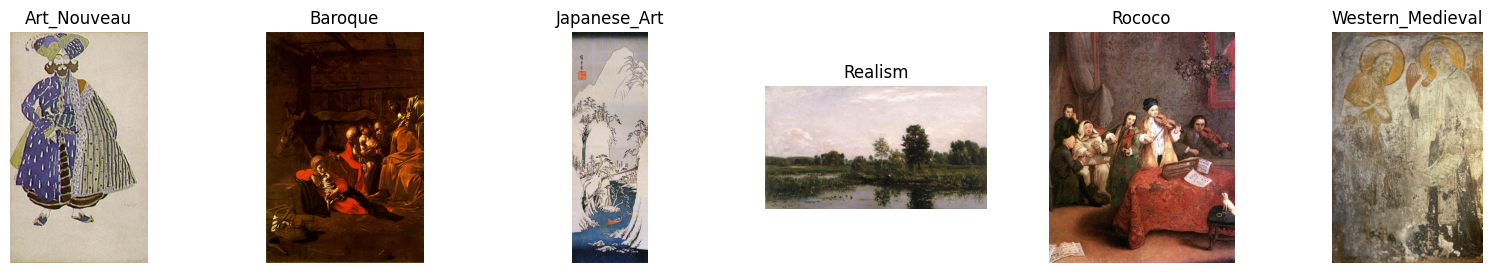

In [21]:
LABELS = ['Art_Nouveau',
          'Baroque',
          'Japanese_Art',
          'Realism',
          'Rococo', 
          'Western_Medieval']

fig = plt.figure(figsize=(20, 3))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
increment = 0
for i in range(6):
    image_path = df['image'].iloc[increment]
    im = Image.open(image_path)
    ax = fig.add_subplot(1, 6, i + 1)
    ax.imshow(im)
    ax.set_title(LABELS[i])
    ax.axis('off')
    increment += num_img_per_class
plt.show()

Además, como vamos a tener que aplicar una serie de pasos de preprocesado, vamos a visualizar cómo quedan las imágenes tras dicho proceso, aunque dicha transformación la realizaremos posteriormente, al aplicar los modelos. 

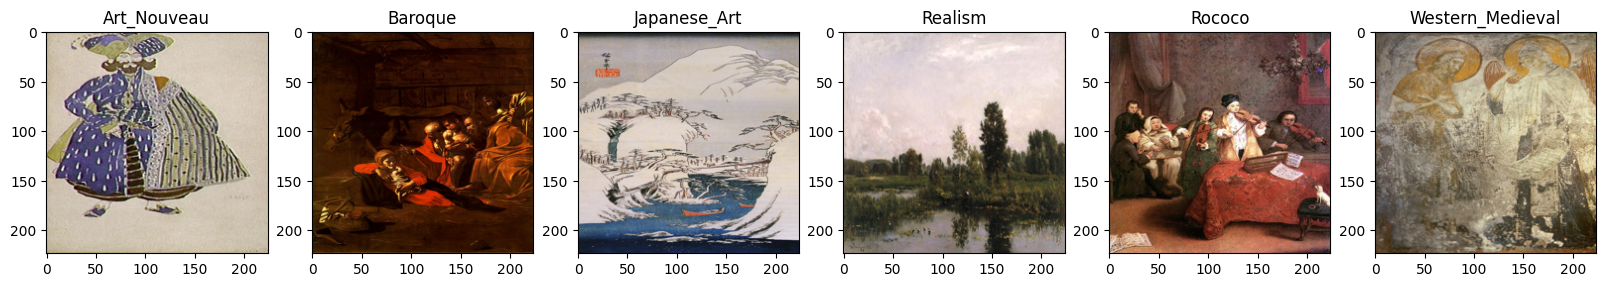

In [22]:
def preprocess_image(image_path, target_size=(224, 224)):
    # Cargar la imagen
    img = Image.open(image_path).convert('RGB')
    # Redimensionar la imagen al tamaño objetivo
    img = img.resize(target_size)
    # Convertir la imagen en un array de numpy y normalizar (escalar píxeles a 0-1)
    img_array = np.array(img) / 255.0
    return img_array

fig = plt.figure(figsize=(20, 3))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
increment = 0
for i in range(6):
    image_path = df['image'].iloc[increment]
    im = preprocess_image(image_path)
    ax = fig.add_subplot(1, 6, i + 1)
    ax.imshow(im)
    ax.set_title(LABELS[i])
    increment += num_img_per_class
plt.show()

Como el dataset ha sido seleccionado manualmente podemos asegurar que no existen duplicados en el conjunto. 